# Model Benchmarking

In this notebook, our focus is on performing multiclass classification to accurately detect and categorize the type of cyber attack. Each model is rigorously trained and tested to differentiate between various attack classes, providing us with the insight needed to identify specific threats.

We start by checking that the data is available otherwise we download it. The data is stored in a `data` folder at the root of the repository.

In [2]:
!ls dataset.zip || {wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V_a2wmNp3o02X2j0PONTtCCPCOn-kiJl" -O dataset.zip && rm -rf /tmp/cookies.txt}

dataset.zip


In [3]:
!ls dataset/ || unzip dataset.zip

'Network datatset'  'Physical dataset'	 preprocessed_csv   README.xlsx


# 1. Dependencies and preprocessing

Before delving into the comparative analysis of our chosen classification models, we begin by setting the foundation for our coding environment. The initial step in our notebook is to import all the necessary dependencies that will facilitate the data preprocessing, model building, visualization, and evaluation tasks. This ensures that all the tools required for our analysis are readily available and operational.

In addition to the standard libraries typically used in data science, such as numpy, pandas, scikit-learn, and matplotlib, we introduce two specialized libraries: precessing and model. The precessing library is crafted to streamline the data preprocessing phase, encapsulating functions for cleaning, normalization, feature extraction, and data splitting. Meanwhile, the model library is designed to abstract the complexity of model training and evaluation. It contains a suite of functions to instantiate, configure, and validate the performance of our Decision Tree Classifier, Random Forest, SVC, MLP, and XGBoost models.

In [1]:
import pandas as pd
import numpy as np
from preprocessing import (
    load_network_csv,
    time_split,
    load_physical_csv,
    generate_binary_labels,
    generate_sample,
)
from models import (
    generate_pipeline,
    plot_confusion_matrix,
    evaluation_report,
    pretty_print_report,
    lof,
    isolation_forest,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier, plot_importance, plot_tree
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

We decided to use only the following files for the network part of the dataset:
- `attack1.csv`
- `attack2.csv`
- `attack3.csv`

The reason is that the other files are too big and would take too much time to process. In the attack files we already have a lot of normal labels, so we decided to use only these files.

In [2]:
network_path_list = [
    "dataset/Network datatset/csv/attack_1.csv",
    "dataset/Network datatset/csv/attack_2.csv",
    "dataset/Network datatset/csv/attack_3.csv",
]
phy_path_list = [
    "dataset/Physical dataset/phy_att_1.csv",
    "dataset/Physical dataset/phy_att_2.csv",
    "dataset/Physical dataset/phy_att_3.csv",
    "dataset/Physical dataset/phy_norm.csv",
]

We start by splitting the data into train and test sets. We use the `train_test_split` function from `sklearn` with a test size of 0.2. But in addition to that, we divided by time. We used the first 80% of the data for training and the last 20% for testing. This is because the data is ordered by time and we want to avoid having data from the future in the training set.

We decided to downsample the entire dataset around 100_000 samples. This is because the dataset is too big and it would take too much time to train the models. We will retrain the model with most promising results on the entire dataset.

In [3]:
df_network = load_network_csv(network_path_list)
df_network.value_counts("label")


label
normal    9851133
DoS       3766586
MITM      1684070
Name: count, dtype: int64

In [4]:
df_network = generate_sample(df_network, 300_000)
df_network.value_counts("label")

label
normal    656746
DoS       251106
MITM      112268
Name: count, dtype: int64

We kept the same ratio between the different classes in order to avoid biasing the models.

In [7]:
X_train_network, X_test_network, y_train_network, y_test_network = time_split(
    df_network, 0.2
)

We start by transforming the data with OneHoteEncoder, SimpleImputer and StandardScaler.

In [5]:
pipeline = generate_pipeline()

In [9]:
pipeline.fit(X_train_network)

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [10]:
X_train_network = pipeline.transform(X_train_network)

In [11]:
X_train_network.shape

(816096, 15)

We apply the same transformations to the test set.

In [12]:
X_test_network = pipeline.transform(X_test_network)

In [13]:
X_test_network.shape

(204024, 15)

Data is clearly imbalanced, so we use SMOTE to balance the data with oversampling on the training set.

In [9]:
smote = SMOTE(random_state=42)
X_train_network, y_train_network = smote.fit_resample(X_train_network, y_train_network)

In [43]:
y_train_network.shape

(408048,)

Preprocessing is done in the `preprocessing.py` file. We decided to use the following preprocessing steps:
- Remove the `Timestamp` column
- Remove data such as ip and mac addresses
- Exploratory data analysis showed some correlation, so we decided to drop `n_pkt_src` and keept only `n_pkt_dst`

Other preprocessing step are described in the `preprocessing.py` file.

In [12]:
df_network.head()

,Time,sport,dport,proto,flags,size,modbus_fn,n_pkt_dst,label
0,2021-04-09 18:23:28.385003,56667.0,502.0,Modbus,11000.0,66,Read Coils Request,0.0,normal
50,2021-04-09 18:23:28.406447,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,24.0,normal
102,2021-04-09 18:23:28.430467,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,50.0,normal
153,2021-04-09 18:23:28.454544,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,49.0,normal
204,2021-04-09 18:23:28.478110,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,15.0,normal


We repeat exactly the same process for the physical data, but we decided to keep the entire dataset.

Preprocessing is done in the `preprocessing.py` file. We decided to use the following preprocessing steps:
- Remove the `timestamp` column
- Encode boolean values as 0 and 1
- Convert object columns to numerical values

In [13]:
df_physical = load_physical_csv(phy_path_list)
X_train_physical, X_test_physical, y_train_physical, y_test_physical = time_split(
    df_physical, 0.2
)

In [14]:
X_train_physical = transform_data(X_train_physical)

In [15]:
df_physical.head()

,Time,Tank_1,Tank_2,Tank_3,Tank_4,Tank_5,Tank_6,Tank_7,Tank_8,Pump_1,...,Valv_14,Valv_15,Valv_16,Valv_17,Valv_18,Valv_19,Valv_20,Valv_21,Valv_22,label
0,2021-04-09 18:23:28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
1,2021-04-09 18:23:29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
2,2021-04-09 18:23:30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
3,2021-04-09 18:23:31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,normal
4,2021-04-09 18:23:32,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,normal


# 2. Model Benchmark on Network Dataset

The primary objective of this notebook is to conduct a thorough comparison of five distinct classification models to determine their effectiveness in the context of attack classification.

## 2.1 Decision Tree Classifier

Decision Tree Classifier is an intuitive model that simulates human decision-making behavior using a tree-like model of decisions and their possible consequences.

In [14]:
decision_tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
decision_tree_clf.fit(X_train_network, y_train_network)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [15]:
X_train_network.shape

(816096, 15)

In [16]:
X_test_network.shape

(204024, 15)

In [17]:
dt_preds = decision_tree_clf.predict(X_test_network)

In [18]:
report = evaluation_report(y_test_network, dt_preds)

In [19]:
pretty_print_report(report)


    Accuracy:           0.9065404070109399
    Balanced Accuracy:  0.5487641367840571
    Precision:          0.8615595046409923
    Recall:             0.9065404070109399
    F1 Score:           0.8711429387681928
    MCC:                0.5342046282493096
    


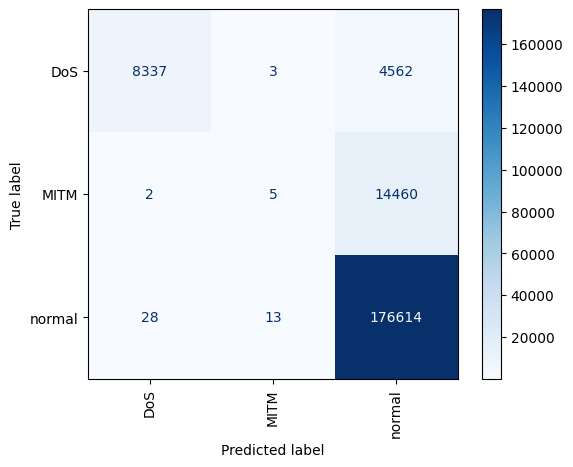

In [22]:
plot_confusion_matrix(y_test_network, dt_preds, decision_tree_clf.classes_)

## 2.2 Random Forest Classifier

Random Forest is an ensemble learning method that constructs a multitude of decision trees at training time and outputs the class that is the mode of the classes of the individual trees.

In [23]:
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
rf_clf.fit(X_train_network, y_train_network)

KeyboardInterrupt: 

In [ ]:
rf_preds = rf_clf.predict(X_test_network)

In [ ]:
report = evaluation_report(y_test_network, rf_preds)
pretty_print_report(report)


    Accuracy:           0.904756303180018
    Balanced Accuracy:  0.5386262599172823
    Precision:          0.8787258621825309
    Recall:             0.904756303180018
    F1 Score:           0.8689295002045436
    MCC:                0.5220050998736978
    


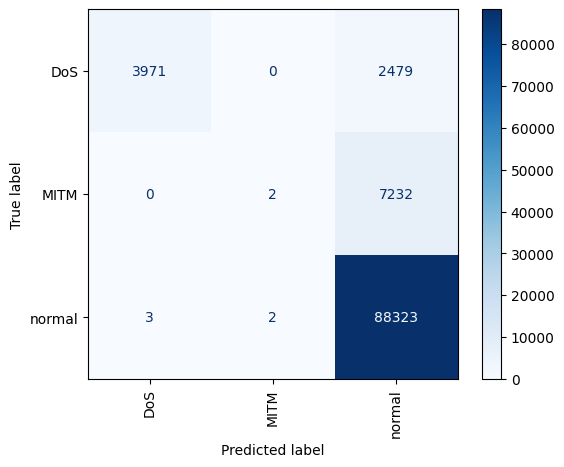

In [ ]:
plot_confusion_matrix(y_test_network, rf_preds, rf_clf.classes_)

## 2.3 BalancedRandomForestClassifier

A balanced random forest randomly under-samples each bootstrap sample to balance it.

In [ ]:
brf_clf = BalancedRandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
brf_pipeline = generate_pipeline(brf_clf, X_train_network, y_train_network)

/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


In [ ]:
brf_preds = brf_pipeline.predict(X_test_network)

In [ ]:
report = evaluation_report(y_test_network, brf_preds)
pretty_print_report(report)


    Accuracy:           0.8876308669568286
    Balanced Accuracy:  0.5435261546626516
    Precision:          0.853819704732551
    Recall:             0.8876308669568286
    F1 Score:           0.866307285384105
    MCC:                0.4312951150267023
    


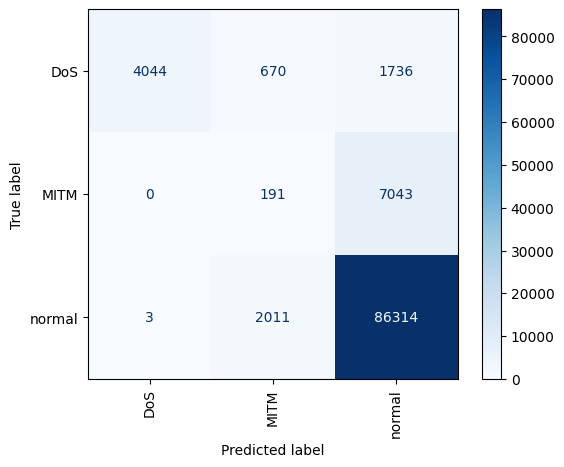

In [ ]:
plot_confusion_matrix(y_test_network, brf_preds, brf_pipeline.classes_)

## 2.4 Support Vector Machine (SVC) Classifier

Svm is a powerful, non-probabilistic binary linear classifier that uses a technique called kernel trick to transform the data and then based on these transformations it finds an optimal boundary between the possible outputs.

In [ ]:
svc = LinearSVC(random_state=42, max_iter=100)
svc_pipeline = generate_pipeline(svc, X_train_network, y_train_network)

/home/h/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/h/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
svc_preds = svc_pipeline.predict(X_test_network)

In [ ]:
report = evaluation_report(y_test_network, svc_preds)
pretty_print_report(report)


    Accuracy:           0.8841900952829079
    Balanced Accuracy:  0.48558823962992353
    Precision:          0.8448675118325868
    Recall:             0.8841900952829079
    F1 Score:           0.8558541665733531
    MCC:                0.38280436764023495
    


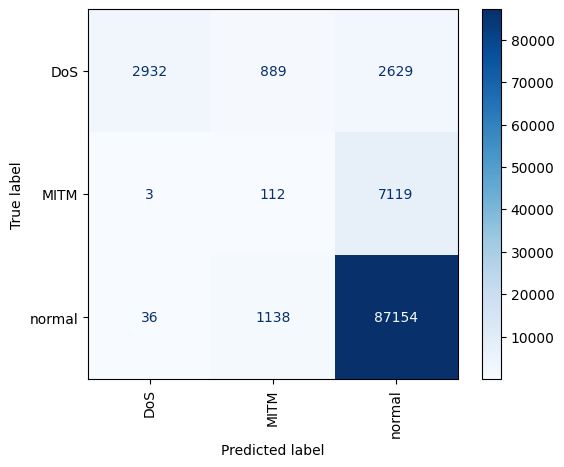

In [ ]:
plot_confusion_matrix(y_test_network, svc_preds, svc_pipeline.classes_)

## 2.5 XGBoost Classifier

XGBClassifier is a highly efficient and scalable implementation of gradient boosted trees designed for speed and performance.

In [ ]:
label_encoder = LabelEncoder()
y_train_network_encoded = label_encoder.fit_transform(y_train_network)

In [ ]:
xgb = XGBClassifier(max_depth=10, n_estimators=30, random_state=42)
xgb_pipeline = generate_pipeline(xgb, X_train_network, y_train_network_encoded) # Xgbost requires label encoding

In [ ]:
xgb_preds = xgb_pipeline.predict(X_test_network)

In [ ]:
xgb_preds = label_encoder.inverse_transform(xgb_preds) # Inverse the label encoding

In [ ]:
report = evaluation_report(y_test_network, xgb_preds)
pretty_print_report(report)


    Accuracy:           0.9064423793279222
    Balanced Accuracy:  0.5480309105497448
    Precision:          0.8664650887617449
    Recall:             0.9064423793279222
    F1 Score:           0.8710384294419792
    MCC:                0.5335418093466614
    


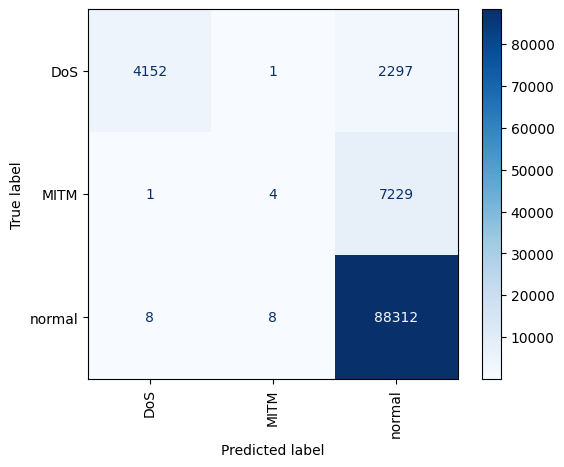

In [ ]:
plot_confusion_matrix(y_test_network, xgb_preds, label_encoder.classes_)

We can now plot feature importance for XGBoost Classifier.

# 2.6 Local outlier factor (LOF)

We now go with unsupervised learning. We use the Local Outlier Factor algorithm to detect outliers in the dataset. We use the function defined in the `model.py` file.

In [ ]:
lof_preds = lof(X_train_network, contamination=0.1)

## 2.7 Isolation Forest

In [ ]:
isolation_forest = isolation_forest(X_train_network, contamination=0.1)

## 2.8 LSTM

## 2.8 Network Dataset Outcomes

This comparative study is expected to yield insightful results that will guide us in selecting the most suitable model for attack classification based on performance metrics. y applying each model to the same test data, we aim to highlight their strengths and weaknesses in a controlled environment, providing a nuanced understanding of their applicability in real-world scenarios.

# 3. Model Benchmark on Physical Dataset

## 3.1 Decision Tree Classifier

In [ ]:
decision_tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_pipeline = generate_pipeline(decision_tree_clf, X_train_physical, y_train_physical)

In [ ]:
dt_preds = dt_pipeline.predict(X_test_physical)

In [ ]:
report = evaluation_report(y_test_physical, dt_preds)
pretty_print_report(report)


    Accuracy:           0.9204819277108434
    Balanced Accuracy:  0.852346721255111
    Precision:          0.9435313592446205
    Recall:             0.9204819277108434
    F1 Score:           0.9288581471935419
    MCC:                0.5682482062712854
    


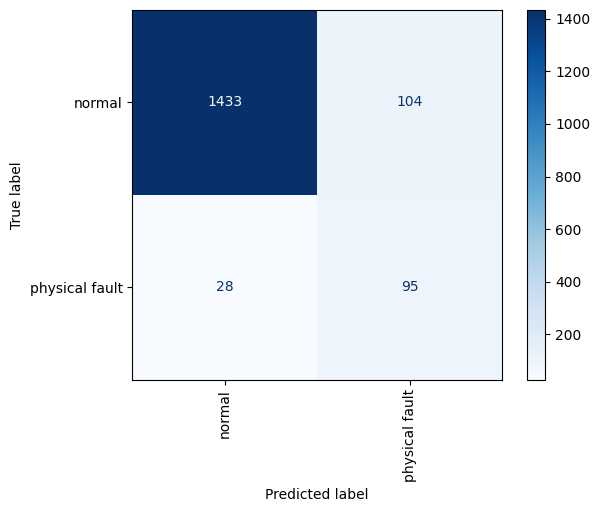

In [ ]:
plot_confusion_matrix(y_test_physical, dt_preds, dt_pipeline.classes_)

## 3.2 Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
rf_pipeline = generate_pipeline(rf_clf, X_train_physical, y_train_physical)

In [ ]:
rf_preds = rf_pipeline.predict(X_test_physical)

In [ ]:
report = evaluation_report(y_test_physical, rf_preds)
pretty_print_report(report)


    Accuracy:           0.9006024096385542
    Balanced Accuracy:  0.6321865528349493
    Precision:          0.8994811062431545
    Recall:             0.9006024096385542
    F1 Score:           0.9000372993798762
    MCC:                0.26739653723329876
    


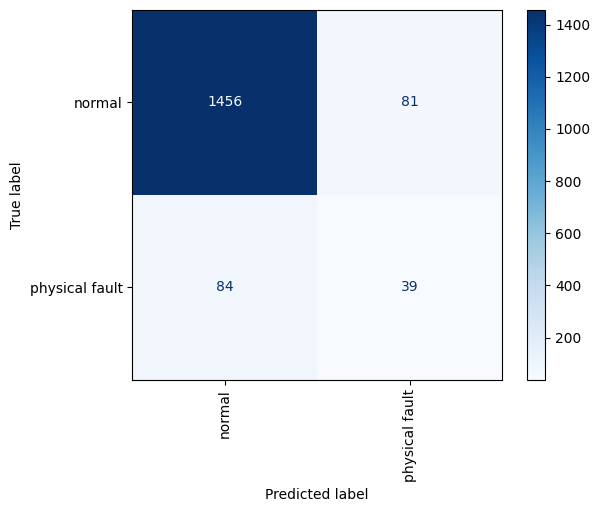

In [ ]:
plot_confusion_matrix(y_test_physical, rf_preds, rf_pipeline.classes_)

## 3.3 BalancedRandomForestClassifier

In [ ]:
brf_clf = BalancedRandomForestClassifier(max_depth=10, n_estimators=30, random_state=42)
brf_pipeline = generate_pipeline(brf_clf, X_train_physical, y_train_physical)

/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/h/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


In [ ]:
brf_preds = brf_pipeline.predict(X_test_physical)

In [ ]:
report = evaluation_report(y_test_physical, brf_preds)
pretty_print_report(report)


    Accuracy:           0.8740963855421687
    Balanced Accuracy:  0.6664894658055234
    Precision:          0.9014621105258844
    Recall:             0.8740963855421687
    F1 Score:           0.8861690416780698
    MCC:                0.27394966716411956
    


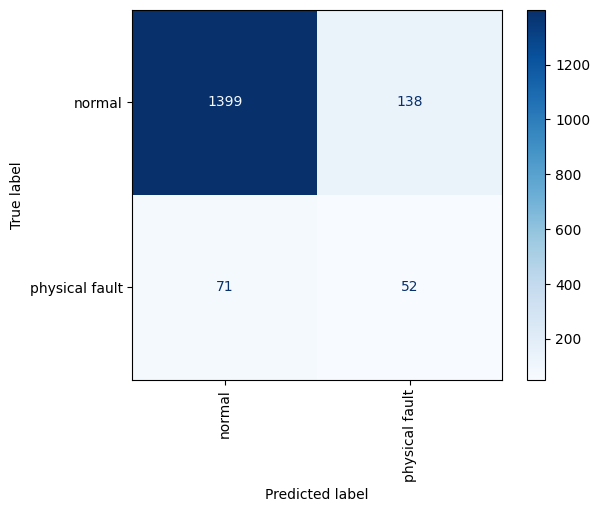

In [ ]:
plot_confusion_matrix(y_test_physical, brf_preds, brf_pipeline.classes_)

## 3.4 Support Vector Machine (SVC) Classifier

In [ ]:
svc = LinearSVC(random_state=42, max_iter=100)
svc_pipeline = generate_pipeline(svc, X_train_physical, y_train_physical)

/home/h/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/h/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
svc_preds = svc_pipeline.predict(X_test_physical)

In [ ]:
report = evaluation_report(y_test_physical, svc_preds)
pretty_print_report(report)


    Accuracy:           0.6596385542168675
    Balanced Accuracy:  0.6591316628846184
    Precision:          0.8990146694544585
    Recall:             0.6596385542168675
    F1 Score:           0.7406656274812183
    MCC:                0.17327091060721475
    


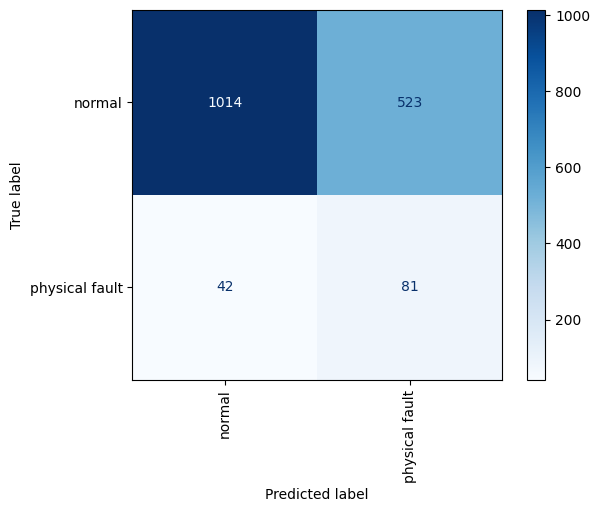

In [ ]:
plot_confusion_matrix(y_test_physical, svc_preds, svc_pipeline.classes_)

## 3.5 XGBoost Classifier

In [ ]:
label_encoder = LabelEncoder()
y_train_physical_encoded = label_encoder.fit_transform(y_train_physical)

In [ ]:
xgb = XGBClassifier(max_depth=10, n_estimators=30, random_state=42)
xgb_pipeline = generate_pipeline(xgb, X_train_physical, y_train_physical_encoded) # Xgbost requires label encoding

In [ ]:
xgb_preds = xgb_pipeline.predict(X_test_physical)

In [ ]:
report = evaluation_report(y_test_physical, label_encoder.inverse_transform(xgb_preds))
pretty_print_report(report)


    Accuracy:           0.8801204819277109
    Balanced Accuracy:  0.8417702101549318
    Precision:          0.9359231680068298
    Recall:             0.8801204819277109
    F1 Score:           0.8996773279420832
    MCC:                0.48369823817912366
    


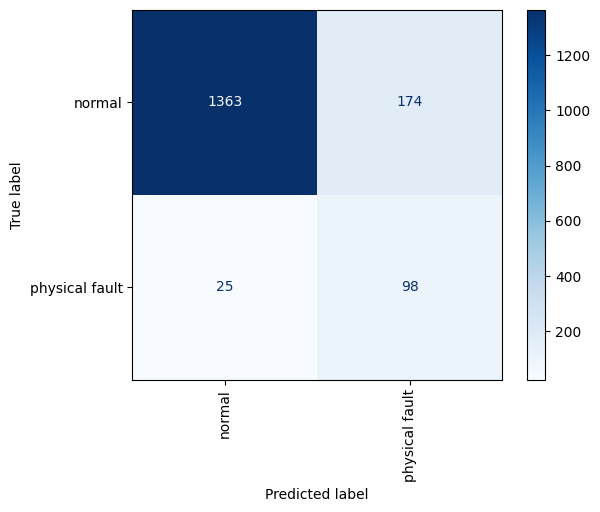

In [ ]:
plot_confusion_matrix(y_test_physical, label_encoder.inverse_transform(xgb_preds), label_encoder.classes_)

## 3.6 Local outlier factor (LOF)

In [ ]:
lof_preds = lof(X_train_physical, contamination=0.1)

# 3.7 Isolation Forest

In [ ]:
if_preds = isolation_forest(X_train_physical, contamination=0.1)

TypeError: 'numpy.ndarray' object is not callable

## 3.8 LSTM

# 3.9 Physical Dataset Outcomes